# Scoring -> PCA -> K-mean

In [1]:
import os
import re
from typing import Dict, Any
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


In [2]:
df = pd.read_csv("../Data/score_v2/condos_scored_all.csv")

In [3]:
df = df.drop(columns='Cluster_Label')

In [4]:
df.head()

,Project_Name,condo_name,Price,Room_Type,Floor,Bedrooms,Bathrooms,Room_Size,Original_Link,district_name,...,price_per_sqm,price_score_0_100,quality_label,value_index,safety_pct_in_district,price_pct_in_district,value_index_pct_in_district,overall_pct_in_district,overall_score_0_100,livability
0,ขายคอนโด เดอะ เซนต์ เรสิเดนเซส อาคาร C ชั้น 29...,The Saint Residences,6790000.0,2 ห้องนอน,29,2 ห้องนอน,2 ห้องน้ำ,57.0,https://propertyhub.in.th/listings/%E0%B8%82%E...,เขตจตุจักร,...,119122.807018,11.706836,Bad,29.174077,7.342657,35.664336,3.496503,2.447552,55.104588,55.104588
1,ขายคอนโด เดอะ ไลน์ จตุจักร-หมอชิต อาคาร 1 ชั้น...,THE LINE Jatujak - Mochit,7900000.0,1 ห้องนอน,24,1 ห้องนอน,1 ห้องน้ำ,40.0,https://propertyhub.in.th/listings/%E0%B8%82%E...,เขตจตุจักร,...,197500.000000,19.562835,Bad,46.581657,49.300699,79.370629,40.909091,51.748252,70.432294,70.432294
2,ขายคอนโด เอ็ม จตุจักร อาคาร B ชั้น 31 2 ห้องนอ...,M Jatujak,7500000.0,2 ห้องนอน,31,2 ห้องนอน,2 ห้องน้ำ,56.0,https://propertyhub.in.th/listings/%E0%B8%82%E...,เขตจตุจักร,...,133928.571429,13.190865,Perfect,62.882246,88.461538,45.279720,84.090909,84.790210,79.293918,79.293918
3,📌 ขายคอนโด เอ็ม จตุจักร อาคาร A ชั้น 8 1 ห้องน...,M Jatujak,3920000.0,1 ห้องนอน,8,1 ห้องนอน,1 ห้องน้ำ,28.0,https://propertyhub.in.th/listings/%E0%B8%82%E...,เขตจตุจักร,...,140000.000000,13.799424,Perfect,62.273687,88.461538,47.902098,82.167832,82.517483,79.111350,79.111350
4,📌 ขายคอนโด เอ็ม จตุจักร อาคาร B ชั้น 14 1 ห้อง...,M Jatujak,5260000.0,1 ห้องนอน,14,1 ห้องนอน,1 ห้องน้ำ,33.0,https://propertyhub.in.th/listings/%E0%B8%82%E...,เขตจตุจักร,...,159393.939394,15.743341,Perfect,60.329770,88.461538,57.692308,78.321678,78.671329,78.528175,78.528175


In [21]:
df['Affordability_Index'] = -1 * df['price_per_sqm']

df.dropna(subset=['Affordability_Index'], inplace=True)

df['weight_price_score'] = -df['price_score_0_100']

features = [
    'Price',
    'Affordability_Index',
    'weight_price_score',
    'latitude',
    'longitude',
    'overall_score_0_100',
]

X = df[features].copy()
processed_indices = X.index 

scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=4)
principal_components = pca.fit_transform(X_scaled_array)
variance_ratios = pca.explained_variance_ratio_
pc1 = principal_components[:, 0]
pc2 = principal_components[:, 1]
# pc3 = principal_components[:, 2]
pc4 = principal_components[:, 3]
    
w1, w2, w3, w4 = variance_ratios[0], variance_ratios[1], variance_ratios[2], variance_ratios[3]
total_weight = w1 + w2 + w4
weighted_score_series = ( (w1 * pc1) + (w2 * pc2) + (w4 * pc4) ) / total_weight

full_score_series = pd.Series(np.nan, index=df.index)
full_score_series.loc[processed_indices] = weighted_score_series

df['Weighted_Composite_Score'] = full_score_series

print("✅ Index corrected. PCA Score assigned successfully.")

# Check the new ranking
df_ranked = df.sort_values(by='Weighted_Composite_Score', ascending=False).dropna(subset=['Weighted_Composite_Score'])

print(f"Total Variance Explained by PC1, PC2, and PC4 (New Features): {total_weight * 100:.2f}%")
print("✅ Weighted Composite Score V2 (including Affordability) created and merged.")

✅ Index corrected. PCA Score assigned successfully.
Total Variance Explained by PC1, PC2, and PC4 (New Features): 79.23%
✅ Weighted Composite Score V2 (including Affordability) created and merged.


In [6]:
variance_ratios

array([0.4930555 , 0.19398787, 0.14771622, 0.10523067])

In [9]:
# View the contribution of each scaled feature to your score (PC1, PC2, PC3)
pc_weights_3 = pd.DataFrame(pca.components_, columns=features, index=['PC1', 'PC2', 'PC3', 'PC4']).T
print("\n### Feature Weights for PC1, PC2, and PC4 (New Features) ###")
print(pc_weights_3)


### Feature Weights for PC1, PC2, and PC4 (New Features) ###
                          PC1       PC2       PC3       PC4
Price               -0.447789  0.016018  0.299653  0.513310
Affordability_Index  0.560352 -0.050078 -0.060768 -0.024840
weight_price_score   0.560352 -0.050078 -0.060768 -0.024840
latitude             0.043794  0.729469 -0.563764  0.383694
longitude            0.094345  0.675339  0.642453 -0.348645
overall_score_0_100  0.400846 -0.080744  0.415026  0.683011


In [10]:
principal_components_filtered = principal_components[:, [0, 1, 3]]
variance_ratios_filtered = variance_ratios[[0, 1, 3]]


X_clusters = principal_components_filtered

In [24]:
# Range of K values to test
# sse = []
# max_k = 10
# for k in range(1, max_k + 1):
#     kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
#     kmeans.fit(X_clusters)
#     sse.append(kmeans.inertia_)

# You would typically plot the 'sse' list to find the elbow,
# but for this guide, we'll assume a good starting point based on common practice.
# e.g., K=4 or K=5 for classifying property tiers.

# For demonstration, let's proceed with K=4 (a common choice for tiered data):
optimal_k = 4
print(f"✅ Assumed optimal number of clusters (K): {optimal_k}")

✅ Assumed optimal number of clusters (K): 4


In [25]:
# Train the K-Means model with the chosen K
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_model.fit_predict(X_clusters)

# Create a temporary DataFrame for the cluster labels using the clean index
cluster_df = pd.DataFrame(
    cluster_labels,
    index=processed_indices,
    columns=['Cluster_Label']
)

# Merge the cluster labels back into the main DataFrame
df_kmean = df.join(cluster_df, how='left')

# Convert the cluster label to a category (or fill NaNs if needed)
df_kmean['Cluster_Label'] = df_kmean['Cluster_Label'].astype('category')

print(f"✅ Properties segmented into {optimal_k} clusters.")

✅ Properties segmented into 4 clusters.


In [26]:
# Identify the key features used for scoring and add Room_Size back for context
analysis_features = [
    'Price',
    'price_per_sqm',
    'price_score_0_100',
    'Room_Size',
    'overall_score_0_100',
    'Cluster_Label'
]

# Calculate the mean of key features for each cluster
cluster_profile = df_kmean[analysis_features].groupby('Cluster_Label').mean().sort_values(by='Price', ascending=False)

print("\n### Cluster Profiles (Group Characteristics) ###")
print(cluster_profile)


### Cluster Profiles (Group Characteristics) ###
                      Price  price_per_sqm  price_score_0_100   Room_Size  \
Cluster_Label                                                               
3              4.745419e+07  373162.052925          37.170009  126.170127   
0              8.932620e+06  164864.277358          16.291651   54.377940   
2              2.554830e+06   68025.779407           6.585216   39.338099   
1              2.087220e+06   62629.450358           6.044324   34.979623   

               overall_score_0_100  
Cluster_Label                       
3                        60.405064  
0                        64.843944  
2                        89.278831  
1                        86.568269  


C:\Users\User\AppData\Local\Temp\ipykernel_2520\1037036588.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_profile = df_kmean[analysis_features].groupby('Cluster_Label').mean().sort_values(by='Price', ascending=False)


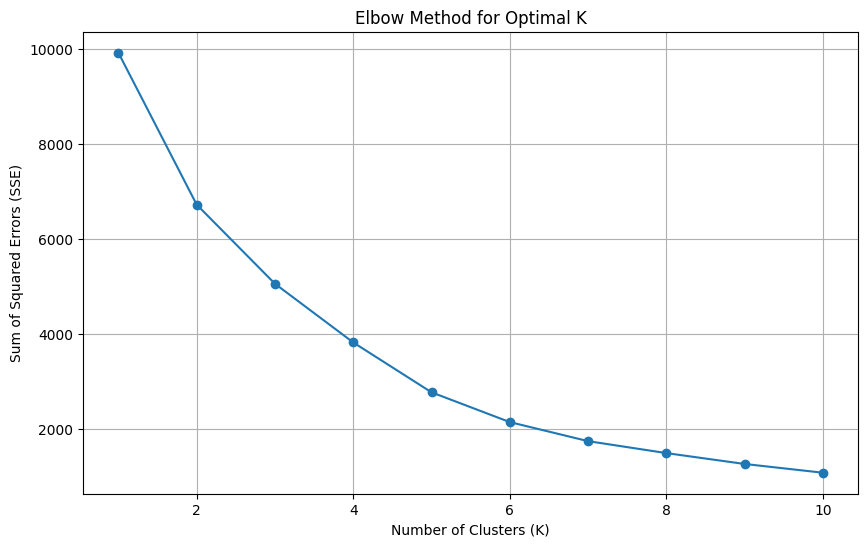

✅ SSE calculated for K=1 to 10.


In [27]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Input data is the array of your three PCs (from the previous step)
X_clusters = principal_components

# Calculate SSE for K from 1 to 10
sse = []
max_k = 10
for k in range(1, max_k + 1):
    # Initialize KMeans and ensure reproducibility with random_state
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_clusters)
    # The 'inertia_' attribute is the SSE
    sse.append(kmeans.inertia_)

# --- Visualization ---
# In a Jupyter Notebook or IDE, you would run the following code to see the plot:
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_k + 1), sse, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.grid(True)
plt.show()

print("✅ SSE calculated for K=1 to 10.")
# The plot would appear here, showing the elbow.

<Figure size 1200x1000 with 0 Axes>

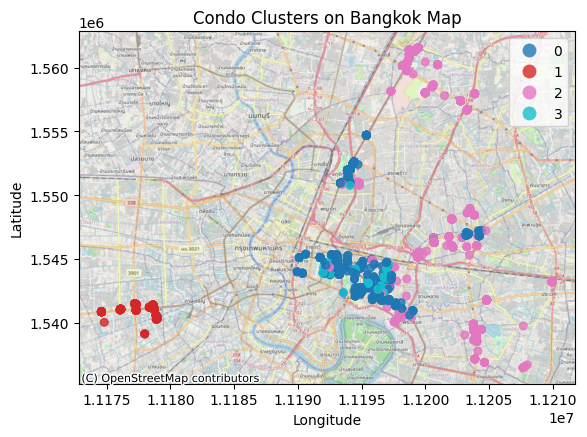

In [28]:
import geopandas as gpd
import contextily as ctx

gdf = gpd.GeoDataFrame(
    df_kmean,
    geometry=gpd.points_from_xy(df_kmean['longitude'], df_kmean['latitude']),
    crs="EPSG:4326",
)
gdf = gdf.to_crs(epsg=3857)

plt.figure(figsize=(12, 10))
ax = gdf.plot(
    ax=None,
    column='Cluster_Label',
    categorical=True,
    legend=True,
    alpha=0.8,
    markersize=30,
)

# use Stamen if available, otherwise fall back to OpenStreetMap
try:
    basemap = ctx.providers.Stamen.TonerLite
except Exception:
    basemap = ctx.providers.OpenStreetMap.Mapnik

ctx.add_basemap(ax, source=basemap)
plt.title('Condo Clusters on Bangkok Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()